In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.plot_feature_reduction import *

# Introduction

We have a lot of input features and many labels. The goal of this Notebook is to see if we can trim the number of input features based on an array of different processing methods. For this Notebook, I will look at the following relationships to determine whether an input feature is relevant:
- correlations
- feature importances
- feature ranking with recursive feature elimination
- Principle Component Analysis (PCA)

Another interesting thing to look at would be to see what output features (labels) we can reasonably expect a machine learning model to predict. For instance, it may be that we can only predict half of the avlanche bulletin's output fields.

# Read in data

In this Notebook, we are setting `days=7` and `with_varsom=False`. We are doing this because when we include the Varsom data, most things are correlated with themselves but from the day before. For example, say we are interested in the `CLASS_drift_slab_dsize` column. Well, the most correlated thing with that column is going to be the destructive size of the drift slab problem from the day before. In essence, the Varsom data is drowning out the RegObs data, which we know should be more important than it has been shown in previous runs of this Notebook. We are also setting the lookback period to 7 days in the hopes of picking up on important features, for example precipitation and temperature data from a week ago may be very important in being able to distinguish between wet and dry avalanche problems.

In [2]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=False)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=False)
    labeled_data.to_csv()

Reading csv


# Data formatting, overall distributions

I go through some of these processing steps (with more printouts) in the Notebook on data distributions, so will not go through them here.

In [3]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [4]:
print(regions.shape)
print(labels.shape)

(13102, 5238)
(13102, 69)


All of our input data set columns are either type int or float. However, there are several columns in the labels that are not.

In [5]:
def check_label_types(l):
    """
    Prints the columns in our labels that have type other than int or float.
    If nothing is printed, all columns are either int or float type.
    
    Arguments:
        l(DataFrame): the output columns we are trying to predict for
    """
    for column in l.columns:
        #if(isinstance(labels[column].dtypes, np.int)):
        is_not_int = l[column].dtype is not np.dtype(np.int64)
        is_not_float = l[column].dtype is not np.dtype(np.float64)

        if(np.logical_and(is_not_int, is_not_float)):
            print(l[column].dtypes, '     ', column)

In [6]:
check_label_types(labels)

object       CLASS_drift_slab_cause
object       CLASS_glide_cause
object       CLASS_new_loose_cause
object       CLASS_new_slab_cause
object       CLASS_pwl_slab_cause
object       CLASS_wet_loose_cause
object       CLASS_wet_slab_cause
object       MULTI_drift_slab_aspect
object       MULTI_glide_aspect
object       MULTI_new_loose_aspect
object       MULTI_new_slab_aspect
object       MULTI_pwl_slab_aspect
object       MULTI_wet_loose_aspect
object       MULTI_wet_slab_aspect


We can first work on the `_cause` columns. Let's see what one of these columns looks like in terms of unique values.

In [7]:
np.unique(labels['CLASS_drift_slab_cause'].astype(str))

array(['0', 'crust', 'new-snow', 'snowdrift'], dtype=object)

We will need to one-hot encode these.

In [8]:
labels.shape

(13102, 69)

In [9]:
labels = encode_causes(labels)

In [10]:
labels.shape

(13102, 89)

So we added 20 columns (while removing the original `_cause` columns) to the data set when we one-hot encoded them.

Now we can move onto the `_aspect` columns. These are more problematic.

In [11]:
aspect_columns = ['MULTI_drift_slab_aspect', 'MULTI_glide_aspect', 'MULTI_new_loose_aspect', 
                  'MULTI_new_slab_aspect', 'MULTI_pwl_slab_aspect', 'MULTI_wet_loose_aspect', 
                  'MULTI_wet_slab_aspect']
labels.loc[:, aspect_columns]

,,MULTI_drift_slab_aspect,MULTI_glide_aspect,MULTI_new_loose_aspect,MULTI_new_slab_aspect,MULTI_pwl_slab_aspect,MULTI_wet_loose_aspect,MULTI_wet_slab_aspect
region,date,,,,,,,
3031,2017-11-22,11100011,00000000,00000000,00000000,00000000,00000000,00000000
3034,2017-11-22,11100011,00000000,00000000,00000000,00000000,00000000,00000000
3031,2017-11-23,11100011,00000000,00000000,00000000,00000000,00000000,00000000
3034,2017-11-23,11100011,00000000,00000000,00000000,00000000,00000000,00000000
3007,2017-11-29,00000000,00000000,00000000,11110001,11110001,00000000,00000000
...,...,...,...,...,...,...,...,...
3031,2021-01-12,00000000,00000000,00000000,00000000,11111111,00000000,00000000
3032,2021-01-12,00000000,00000000,00000000,00000000,11111111,00000000,00000000
3034,2021-01-12,00000000,00000000,00000000,00000000,11111111,00000000,00000000


In [12]:
for i, row in enumerate(range(11)):
    print(i, labels.loc[:, aspect_columns].replace('00000000', np.nan).iloc[i, :].values)

0 ['11100011' nan nan nan nan nan nan]
1 ['11100011' nan nan nan nan nan nan]
2 ['11100011' nan nan nan nan nan nan]
3 ['11100011' nan nan nan nan nan nan]
4 [nan nan nan '11110001' '11110001' nan nan]
5 [nan nan nan '11110001' '11110001' nan nan]
6 [nan nan nan '11110001' '11110001' nan nan]
7 [nan nan nan '11110001' '11110001' nan nan]
8 [nan nan nan '11110001' '11110001' nan nan]
9 ['11111111' nan nan nan nan nan nan]
10 ['10000011' nan nan nan '11100011' nan nan]


Okay, so we see that at index 10, we have two values for a given region on a given day for the aspect on the avalanche bulletin. This is because more than one problem can be given at a time (up to 3, but most often 1 or 2). So we can't split this into 7 distinct columns, 1 for each aspect/avalanche problem combination, but instead we have to one-hot encode each of these columns into *8* different columns, for a total of 56 columns. This is disappointing when we are trying to cut down on the size of the data, but there is no other way around it unless we wanted to drop these columns altogether (which we don't).

In [13]:
labels = encode_aspects(labels)
labels.shape

(13102, 138)

We had 89 columns after encoding the cause, plus 56 aspect columns and subtracting the 7 original aspect columns, that gives us 138. Let's make sure that we did the encoding correctly.

In [14]:
test_col = 'MULTI_drift_slab_aspect'
check_cols = [test_col+'_'+str(i) for i in list(range(0, 8))]
compare = labels.loc[:, check_cols][:11]

for row in range(len(compare.index)):
    element_list = [''+str(element) for element in compare.iloc[row].values]
    to_print = ''.join(element_list)
    if(to_print == '00000000'):
        print(row, np.nan)
    else:
        print(row, to_print)

0 11100011
1 11100011
2 11100011
3 11100011
4 nan
5 nan
6 nan
7 nan
8 nan
9 11111111
10 10000011


This is looking good. We can compare this output to the first column in the printout above when we were intially checking for duplicate entries.

Now we should not have any columns that are not of type float or int in our labels, so the following loop should not produce any output.

In [15]:
check_label_types(labels)

# Further Data Processing

After looking at the output of this Notebook a few times, there are a few improvements that we want to try to make with the RegObs columns.
- `wind_dir_#` columns can be dropped.
- `wind_speed_#` and `wind_change_speed_#` should be combined into a new feature `wind_speed_max_#`, which is the max of `wind_speed_#` and `wind_change_speed_#`. Then these two original wind columns can be dropped.
- `wind_speed_max_0`, `wind_speed_max_1`, `wind_speed_max_2` should be summed to `wind_speed_max_72hr` and then these three input columns can be dropped.
- `precip_0`, `precip_1`, `precip_2` should be summed to `precip_72hr` and then `precip_1` and `precip_2` can be dropped.

## Additional notes
- We cannot do this sum over time for the `precip_most_exposed` columns since this may not be valid for the same area over time.
- Also, we may need to think of a way to combine the `temp_freeze_#` columns, like perhaps taking the min, max, and average over a given time.

### Drop `wind_dir` columns

In [16]:
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
print(wind_dir_cols[:10])
regions.drop(wind_dir_cols, axis=1, inplace=True)

['wind_dir_N_0', 'wind_dir_N_1', 'wind_dir_N_2', 'wind_dir_N_3', 'wind_dir_N_4', 'wind_dir_N_5', 'wind_dir_NE_0', 'wind_dir_NE_1', 'wind_dir_NE_2', 'wind_dir_NE_3']


### Create `wind_max` columns

In [17]:
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions.loc[:, wind_speed_cols]

,,wind_speed_0,wind_speed_1,wind_speed_2,wind_speed_3,wind_speed_4,wind_speed_5,wind_change_speed_0,wind_change_speed_1,wind_change_speed_2,wind_change_speed_3,wind_change_speed_4,wind_change_speed_5
region,date,,,,,,,,,,,,
3031,2017-11-22,18.5,5.5,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-22,18.5,9.0,5.5,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3031,2017-11-23,15.5,18.5,5.5,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,18.5,18.5,9.0,5.5,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-11-29,12.0,12.0,5.5,12.0,12.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,9.0,5.5,5.5,5.5,0.0,0.0,0.0,0.0,0.0,15.5,0.0,0.0
3032,2021-01-12,12.0,5.5,9.0,5.5,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0
3034,2021-01-12,9.0,5.5,9.0,5.5,5.5,5.5,0.0,0.0,0.0,12.0,0.0,0.0


In [18]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    df.drop(col_list, axis=1, inplace=True)
    return df

In [19]:
regions = wind_speed_max(regions, wind_speed_cols)

# now our wind speed columns only contain maxima
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
wind_speed_cols

['wind_speed_max_0',
 'wind_speed_max_1',
 'wind_speed_max_2',
 'wind_speed_max_3',
 'wind_speed_max_4',
 'wind_speed_max_5']

### Sum over `wind_speed_max` columns

In [20]:
def sum_over_features(df, col_list, new_name):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    df.drop(col_list, axis=1, inplace=True)
    return df

In [21]:
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_max_72hr')

# print all wind speed columns again to check for new column
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
wind_speed_cols

['wind_speed_max_3',
 'wind_speed_max_4',
 'wind_speed_max_5',
 'wind_speed_max_72hr']

### Sum over `precip` columns

We can use the method we wrote above to do the same thing for the precipitation columns. However, this time around we want to keep the "day-of" value for precipitation (`precip_0`).

In [23]:
# we need to get precip_ columns, not precip_most_exposed_ columns
precip_cols = [col for col in regions.columns if 'precip' in col and 'most_exposed' not in col]
precip_cols

['precip_0', 'precip_1', 'precip_2', 'precip_3', 'precip_4', 'precip_5']

In [25]:
todays_precip = regions.loc[:, ['precip_0']]
todays_precip

,,precip_0
region,date,
3031,2017-11-22,25.7
3034,2017-11-22,47.0
3031,2017-11-23,55.4
3034,2017-11-23,53.1
3007,2017-11-29,9.3
...,...,...
3031,2021-01-12,0.0
3032,2021-01-12,0.0
3034,2021-01-12,0.0


In [26]:
to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

# now concatenate precip_0 column back in
regions = pd.concat([regions, todays_precip], axis=1)

# print all precip columns again to check for new column
precip_cols = [col for col in regions.columns if 'precip' in col and 'most_exposed' not in col]
precip_cols

['precip_3', 'precip_4', 'precip_5', 'precip_72hr', 'precip_0']

# Correlation analysis

The most important features that we need to predict for the avalanche bulletin are danger level, avalanche problem 1 and 2, the `dsize`, `dist`, `prob`, and `trig`, and problem amount. We can isolate these columns so that they can be used in later parts of the Notebook as well.

Additionally, we can think about the most important element in the avalanche bulletin being the first avalanche problem. We can then rank the importance of each component of the first avalanche problem like so:
1. `dsize` (destructive size)
2. sensitivity to triggers, which is a combination of `prob` and `trig`
    - `prob`: avalanche probability (possible, likely, unlikely, etc.)
    - `trig`: avalanche trigger (large/small, natural/artificial)
3. `dist` (avalanche distribution)
4. avalanche problem type
5. level min and max
6. aspect (on which side of the mountain does the problem exist)

Of secondary importance is problem 2, but the steps for that would look very similar to what we outlined above for problem 1.

In [28]:
dsize_cols = [col for col in labels.columns if 'dsize' in col]
dist_cols = [col for col in labels.columns if 'dist' in col]
trig_cols = [col for col in labels.columns if 'trig' in col]

# we want to filter out the problem columns from the probability columns
proba_cols = [col for col in labels.columns if 'prob' in col and 'problem' not in col]

# lump danger level in with the problems 1 and 2
problem_cols = ['CLASS_danger_level', 'CLASS_problem_1', 'CLASS_problem_2']

In [29]:
features_and_labels = features = pd.concat([regions, labels], axis=1)
features_and_labels.shape

(13102, 5319)

The code below will compute the correlations for each of ~4800 input features and every ~140 output features, which takes a very long time. You  will have to run this code the first time through the Notebook, but after that you can load the correlations DataFrame from file using the code I have in the following cells.

In [30]:
# drop columns that include text, create correlations matrix
only_numeric = features_and_labels.select_dtypes(include='number')
correlations = only_numeric.corr()

# shorten the x axis to only the labels
keep_cols = [col for col in labels if col in correlations.columns]
drop_rows = list(set(correlations.columns) - set(keep_cols))
correlations = correlations.loc[drop_rows, keep_cols]

# there are some rows with only nan values, we can drop those here
empty_rows = [item for item in correlations.index if correlations.loc[item].isna().all() == True]
correlations.drop(empty_rows, inplace = True)

In [31]:
# to save after running for the first time
np.save('./data/correlations.npy', correlations.values)
    
with open('./data/correlations_index.txt', 'wb') as file:
    pickle.dump(correlations.index.values, file)
    
with open('./data/correlations_columns.txt', 'wb') as file:
    pickle.dump(correlations.columns.values, file)

In [32]:
# to load after having saved
corr_array = np.load('./data/correlations.npy')

with open ('./data/correlations_index.txt', 'rb') as file:
    corr_index = pickle.load(file)
    
with open ('./data/correlations_columns.txt', 'rb') as file:
    corr_cols = pickle.load(file)
    
correlations = pd.DataFrame(corr_array, index=corr_index, columns=corr_cols)

In [33]:
correlations.shape

(4839, 138)

**Another thing to try would be to drop all rows where the absolute value of the correlation is below some threshold value for all values (taking the absolute value, of course, since correlations can be negative). These input features probably don't need to be considered.**

In [34]:
threshold = 0.3
np.sum([(abs(correlations.loc[idx, :].values) < threshold).all() for idx in correlations.index])

4820

In [35]:
weak_correlations = [(abs(correlations.loc[idx, :].values) < threshold).all() for idx in correlations.index]
correlations.loc[weak_correlations, :].shape

(4820, 138)

In [36]:
sorted(correlations.loc[weak_correlations, :].index)[:100]

['accuracy_2',
 'accuracy_3',
 'accuracy_4',
 'accuracy_5',
 'accuracy_6',
 'accuracy_7',
 'precip_0',
 'precip_3',
 'precip_4',
 'precip_5',
 'precip_72hr',
 'precip_most_exposed_0',
 'precip_most_exposed_1',
 'precip_most_exposed_2',
 'precip_most_exposed_3',
 'precip_most_exposed_4',
 'precip_most_exposed_5',
 'regobs_activity_aval_propagation_0_2',
 'regobs_activity_aval_propagation_0_3',
 'regobs_activity_aval_propagation_0_4',
 'regobs_activity_aval_propagation_0_5',
 'regobs_activity_aval_propagation_0_6',
 'regobs_activity_aval_propagation_0_7',
 'regobs_activity_aval_propagation_1_2',
 'regobs_activity_aval_propagation_1_3',
 'regobs_activity_aval_propagation_1_4',
 'regobs_activity_aval_propagation_1_5',
 'regobs_activity_aval_propagation_1_6',
 'regobs_activity_aval_propagation_1_7',
 'regobs_activity_aval_propagation_2_2',
 'regobs_activity_aval_propagation_2_3',
 'regobs_activity_aval_propagation_2_4',
 'regobs_activity_aval_propagation_2_5',
 'regobs_activity_aval_propaga

In [37]:
drop_weak = correlations.loc[weak_correlations, :].index.values
correlations.drop(drop_weak).shape

(19, 138)

Are there also labels that are going to be hard to predict in the avalanche bulletin? We can look at the columns in our correlation matrix in the same way that we did for the input features.

In [38]:
np.sum([(abs(correlations.loc[:, col].values) < threshold).all() for col in correlations.columns])

100

In [39]:
weak_labels = [(abs(correlations.loc[:, col].values) < threshold).all() for col in correlations.columns]
drop_weak_labels = correlations.loc[:, weak_labels].columns
sorted(correlations.loc[:, weak_labels].columns.values)

['CLASS_drift_slab_cause_crust',
 'CLASS_drift_slab_cause_new_snow',
 'CLASS_drift_slab_cause_snowdrift',
 'CLASS_emergency_warning',
 'CLASS_glide_cause_0',
 'CLASS_glide_cause_ground_water',
 'CLASS_glide_dist',
 'CLASS_glide_dsize',
 'CLASS_glide_lev_fill',
 'CLASS_glide_prob',
 'CLASS_glide_trig',
 'CLASS_new_loose_cause_0',
 'CLASS_new_loose_cause_loose',
 'CLASS_new_loose_dist',
 'CLASS_new_loose_dsize',
 'CLASS_new_loose_lev_fill',
 'CLASS_new_loose_prob',
 'CLASS_new_loose_trig',
 'CLASS_new_slab_cause_0',
 'CLASS_new_slab_cause_crust',
 'CLASS_new_slab_cause_new_snow',
 'CLASS_new_slab_dist',
 'CLASS_new_slab_dsize',
 'CLASS_new_slab_lev_fill',
 'CLASS_new_slab_prob',
 'CLASS_new_slab_trig',
 'CLASS_problem_2',
 'CLASS_problem_3',
 'CLASS_problem_amount',
 'CLASS_pwl_slab_cause_crust_above_facet',
 'CLASS_pwl_slab_cause_crust_below_facet',
 'CLASS_pwl_slab_cause_facet',
 'CLASS_pwl_slab_cause_ground_facet',
 'CLASS_pwl_slab_cause_hoar',
 'CLASS_pwl_slab_lev_fill',
 'CLASS_wet_

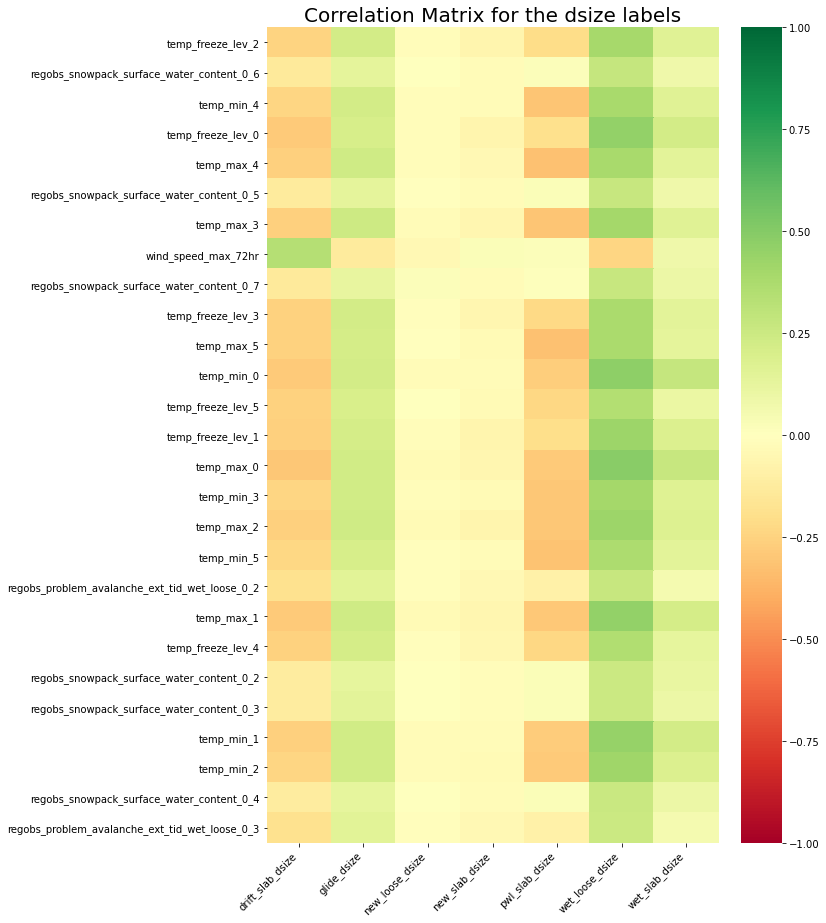

In [40]:
plot_correlations(correlations, 0.25, dsize_cols, 'dsize')

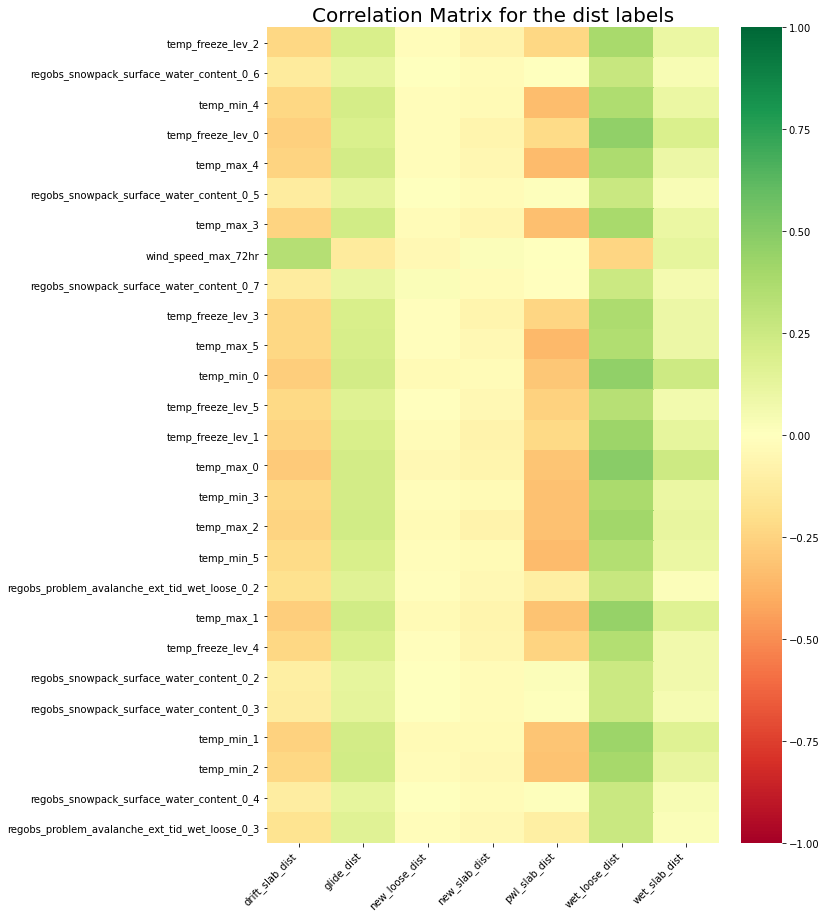

In [41]:
plot_correlations(correlations, 0.25, dist_cols, 'dist')

So temperature is much more correlated with wet avalanche distribution and glide avalanche problem destruction size and distribution, as is surface water content. Still, it is surprising to not see precipitation featured here.

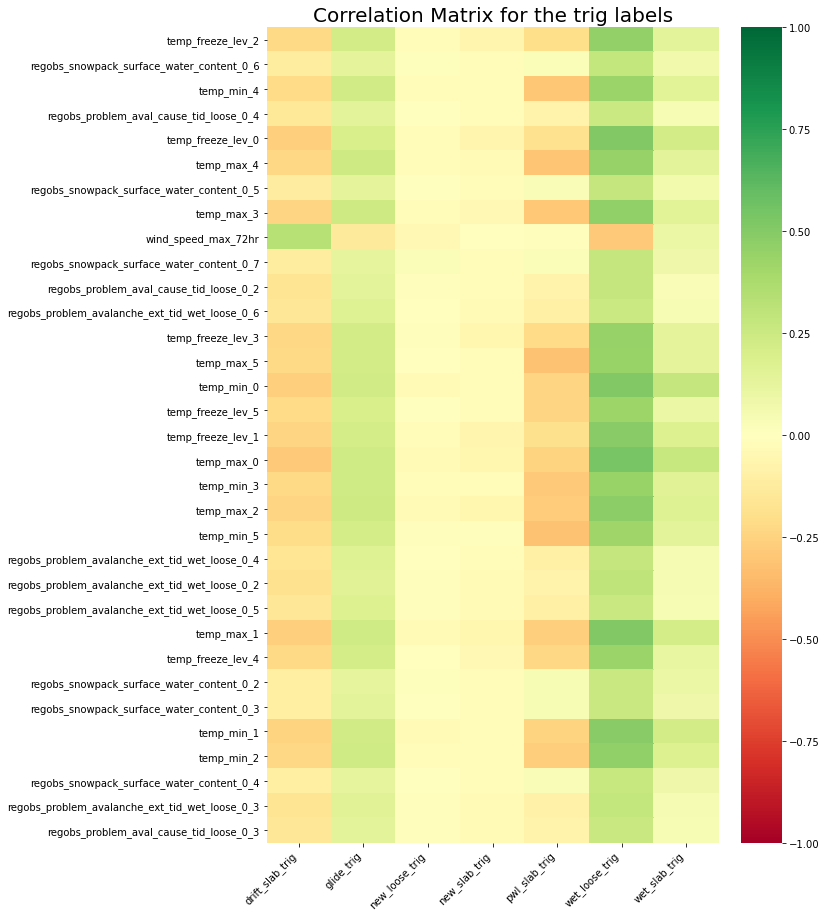

In [42]:
plot_correlations(correlations, 0.25, trig_cols, 'trig')

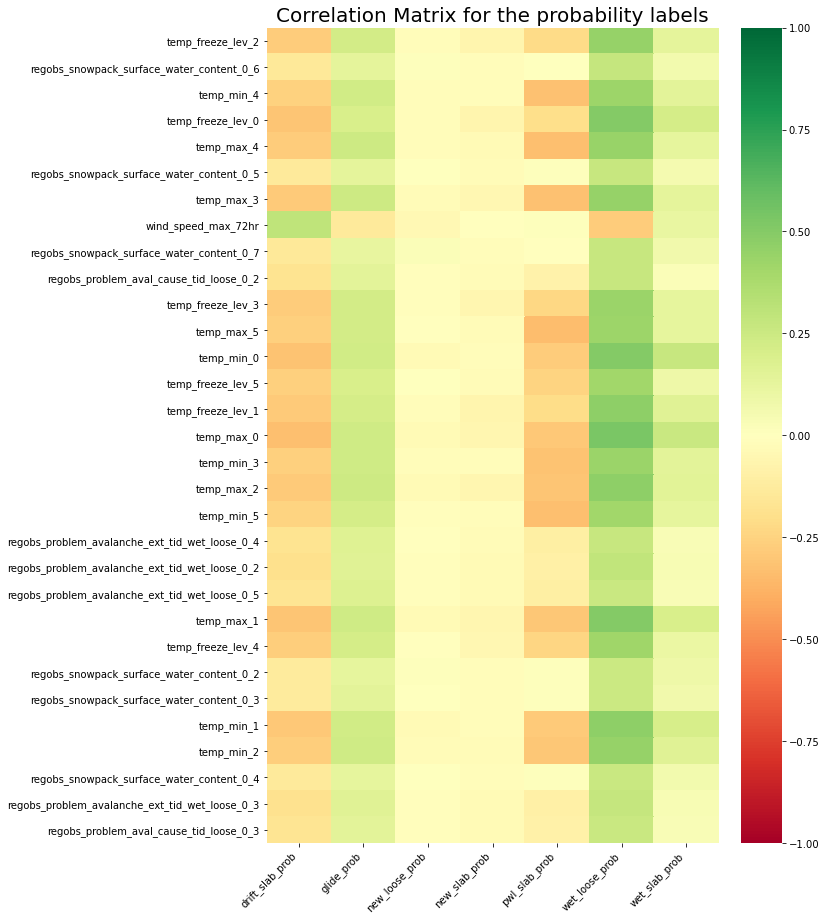

In [43]:
plot_correlations(correlations, 0.25, proba_cols, 'probability')

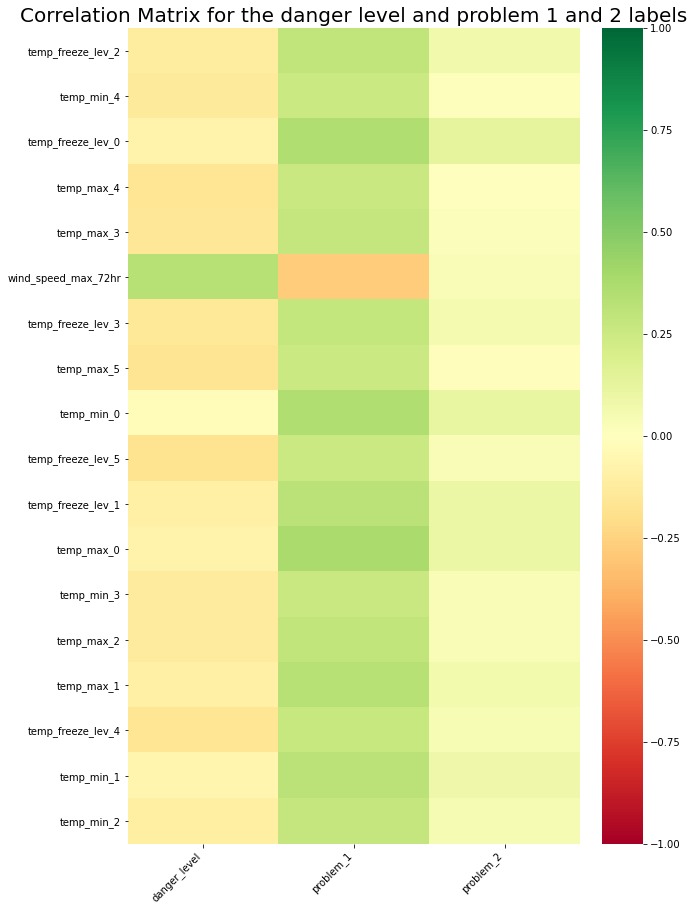

In [44]:
plot_correlations(correlations, 0.25, problem_cols, 'danger level and problem 1 and 2')

**So we see that the `new-loose` avalanche problem isn't highly correlated with anything, mainly because it is rarely used. And when it is used, it is mainly as a placeholder. We see that wet avalanches are more highly correlated with temperature components (`min`, `max`, `freezing_level`) and snowpack surface water content from RegObs data.**

**Lastly, it was interesting to see that danger level was mostly correlated with maximum of the wind speed or wind speed change over the last 72 hours relating to the wind slab avalanche problem**.

# Feature importances

Next, we can look at which features a Random Forest model thinks are important. To do this, we can use the whole dataset as a predictor for the labels.

In [45]:
X, y = regions.select_dtypes(include='number'), labels.select_dtypes(include='number')

# isolate labels for each set of labels we care about
y_dsize = y.loc[:, dsize_cols]
y_dist = y.loc[:, dist_cols]
y_trig = y.loc[:, trig_cols]
y_proba = y.loc[:, proba_cols]

# and now danger level, problem 1 and 2
y_danger = y.loc[:, problem_cols[0]]
y_problem_1 = y.loc[:, problem_cols[0]]
y_problem_2 = y.loc[:, problem_cols[0]]

In [46]:
# make a models/ directory if there is none
if('models' not in os.listdir()):
    print('Creating models/ folder in this directory.')
    os.mkdir('./models/')

Training the model only needs to be done once (it takes a long time). If you have already run it, the models will already have been saved for you in the `./models` directory that we created above. That means that we can load them directly, saving us a lot of time.

In [47]:
# train all models here
model_dsize = train_forest(X, y_dsize, 'dsize')
model_dist = train_forest(X, y_dist, 'dist')
model_trig = train_forest(X, y_trig, 'trig')
model_proba = train_forest(X, y_proba, 'proba')
model_danger = train_forest(X, y_danger, 'danger_level')
model_problem_1 = train_forest(X, y_problem_1, 'problem_1')
model_problem_2 = train_forest(X, y_problem_2, 'problem_2')

Training model on dsize label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...

Training model on dist label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...

Training model on trig label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...

Training model on proba label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...

Training model on danger_level label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...

Training model on problem_1 label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...

Training model on problem_2 label(s)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Saving model...



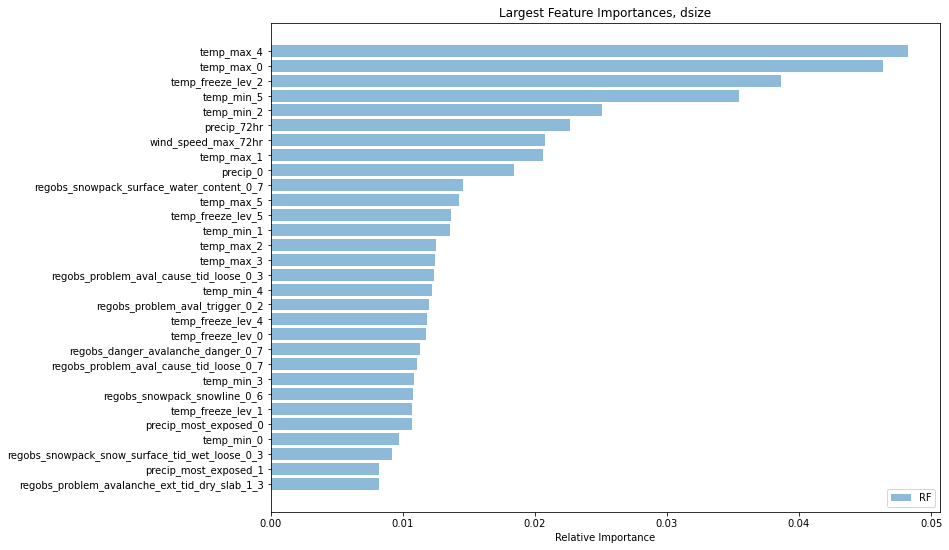

In [48]:
# dsize labels
title = 'dsize'
model = model_dsize
ranked_importances, ranked_columns = plot_importances(regions, model, title, True)

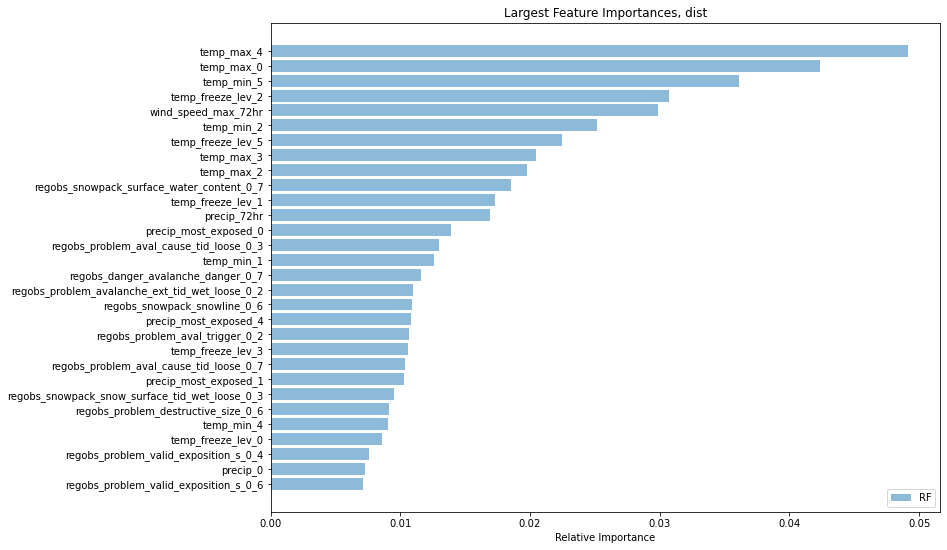

In [49]:
# dist labels
title = 'dist'
model = model_dist
ranked_importances, ranked_columns = plot_importances(regions, model, title, True) 

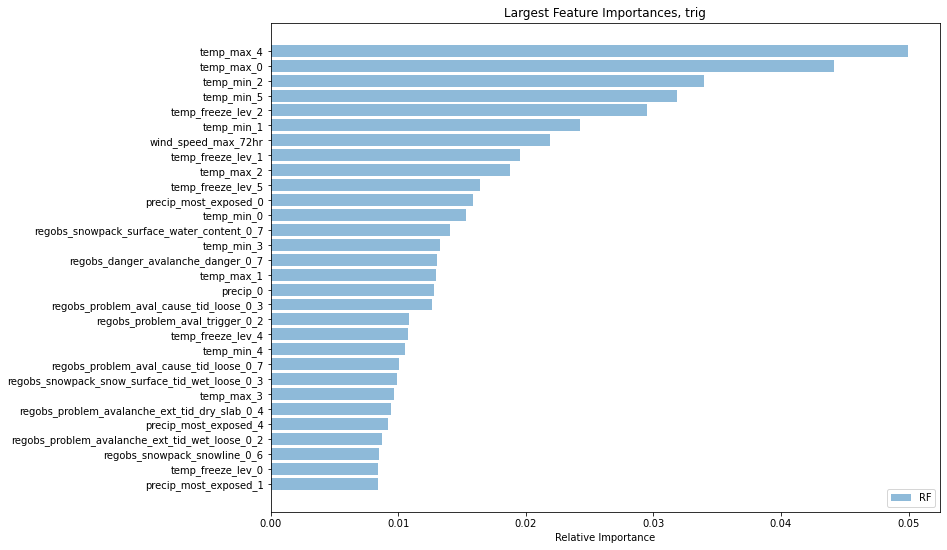

In [50]:
# trig labels
title = 'trig'
model = model_trig
ranked_importances, ranked_columns = plot_importances(regions, model, title, True) 

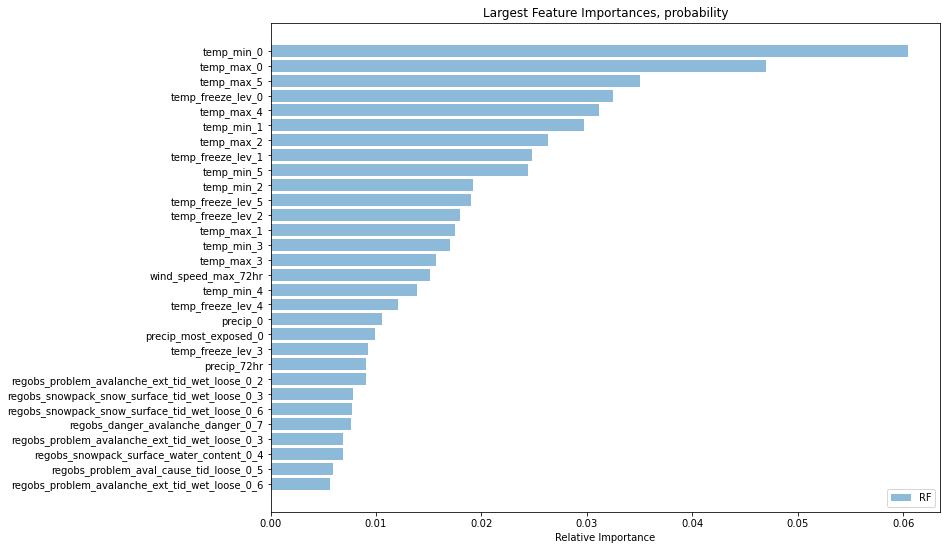

In [51]:
# prob labels
title = 'probability'
model = model_proba
ranked_importances, ranked_columns = plot_importances(regions, model, title, True) 

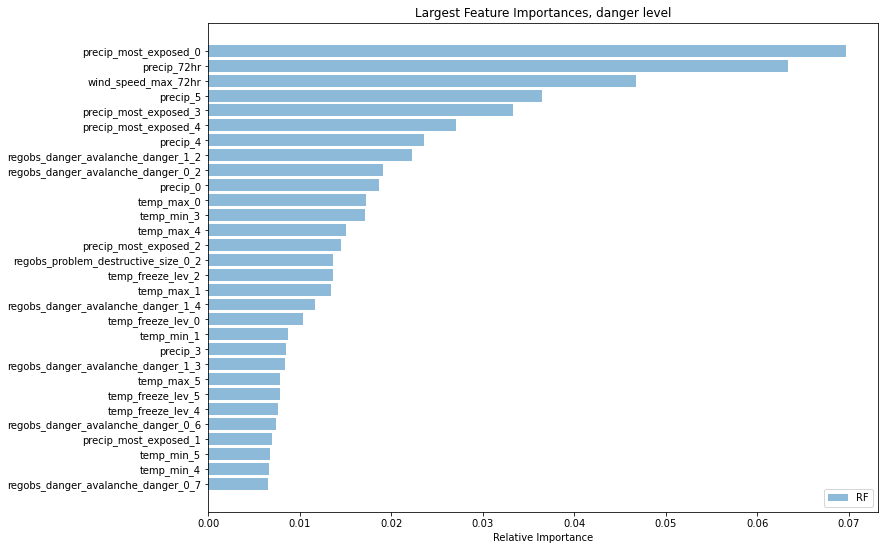

In [52]:
# danger level
title = 'danger level'
model = model_danger
ranked_importances, ranked_columns = plot_importances(regions, model, title, True) 

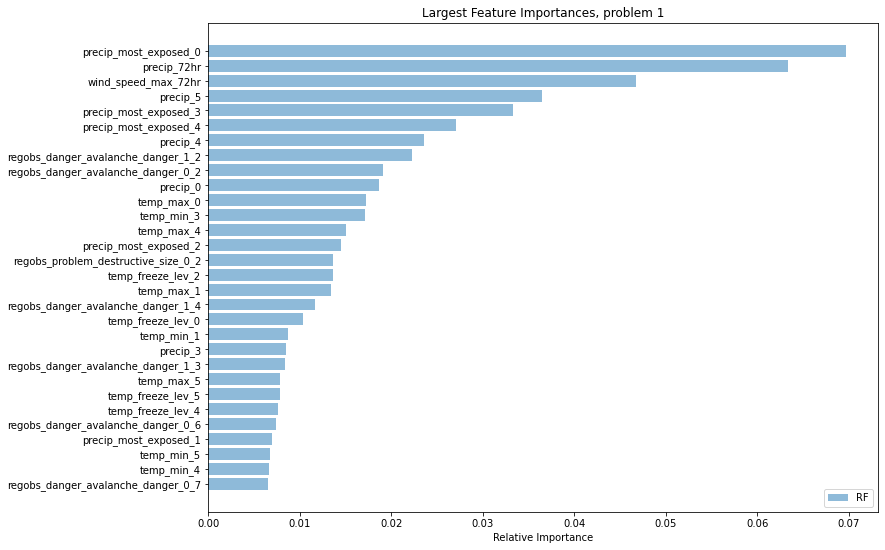

In [53]:
# avalanche problem 1
title = 'problem 1'
model = model_problem_1
ranked_importances, ranked_columns = plot_importances(regions, model, title, True) 

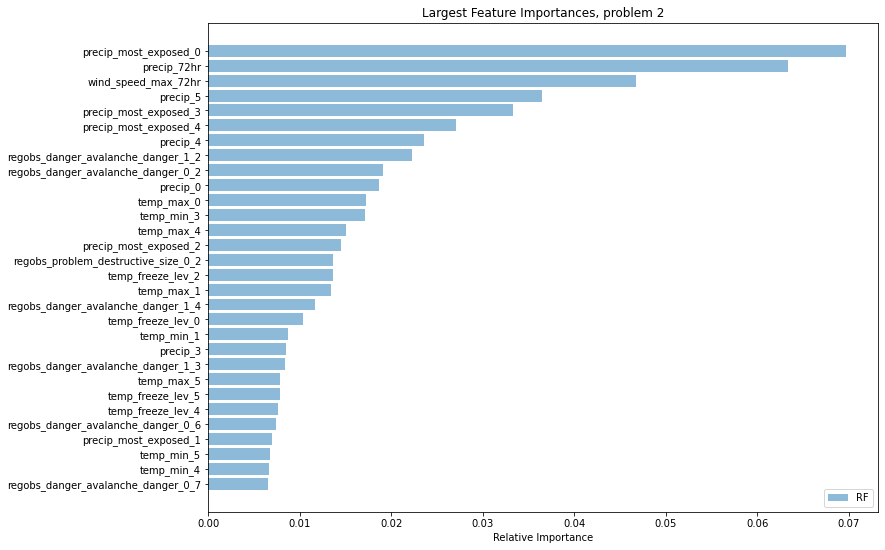

In [54]:
# avalanche problem 1
title = 'problem 2'
model = model_problem_2
ranked_importances, ranked_columns = plot_importances(regions, model, title, True) 

**For the `dsize`, `dist`, `trig`, and `prob` columns, the most important input features are all the same. They are:**
- the temperature maximum and freezing level
- the precipitation for the week
- the snowpack surface water content

**For the danger level the most important features are precipitation the day of and 1 and 2 days ago, wind speed the day of, as well as the maximum temperature 2 and 5 days ago.**

**Avalanche problems follow a similar pattern: they are influenced mainly by precipitation up to 4 days ago, and the strange temperature max and min 2 and 5 days in the past is present.**

# Principal Component Analysis

My goal for this section is to perform PCA on our input data as a means of dimensionality reduction. I want to see if there are any variables that explain some amount of shared variance (meaning that they contribute nothing extra to our analysis). If this is the case, we can drop those columns and save compute resources.

We can do this because Principle Components are orthogonal: this means that they should be completely uncorrelated with each other.

Thank you to these two excellent resources on how to compute the loadings matrix after doing PCA:
- https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
- https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

In [55]:
# appply feature scaling
scaler = StandardScaler()

# fit and transform the data in one step
# now we move from a dataframe to a numpy array
scaled = pd.DataFrame(scaler.fit_transform(regions), columns=regions.columns, index=regions.index)
scaled.head()

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_3,precip_4,precip_5,temp_min_0,...,accuracy_4,accuracy_5,accuracy_6,accuracy_7,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_max_72hr,precip_72hr,precip_0
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,0.072600,-0.064121,-0.061388,-0.064952,0.040745,0.046786,-0.056038,0.031426,0.035974,-0.510164,...,-0.313097,-0.312239,-0.311303,-0.310591,-0.890183,-2.057479,-2.060416,-0.460931,-0.039401,0.043166
3034,2017-11-22,0.152894,-0.047401,-0.066443,-0.065341,0.045411,0.073227,-0.055649,0.039593,0.059309,-0.557972,...,-0.313097,-0.312239,-0.311303,-0.310591,-0.147177,-2.057479,-2.060416,0.360948,0.013937,0.126002
3031,2017-11-23,0.243491,0.072554,-0.064110,-0.061453,-0.065019,0.040565,-0.054482,-0.056077,0.031307,0.350375,...,-0.313097,-0.312239,-0.311303,-0.310591,-2.057763,-0.889508,-2.060416,0.954528,0.083928,0.158669
3034,2017-11-23,0.189833,0.152848,-0.047390,-0.066508,-0.065407,0.045231,-0.056815,-0.055688,0.039474,0.334439,...,-0.313097,-0.312239,-0.311303,-0.310591,-0.890183,-0.146254,-2.060416,1.548107,0.133440,0.149725
3007,2017-11-29,-0.028691,-0.000741,-0.038446,-0.063786,-0.066574,-0.053534,-0.055649,-0.056854,-0.045695,-0.366741,...,-0.313097,-0.312239,-0.311303,-0.310591,0.489685,0.490822,2.827160,0.041328,-0.032424,-0.020614


In [56]:
# fit and transform the data here, create principal components
pca = PCA()
pcs = pca.fit_transform(scaled)

# print the explained variance ratio of the first ten principal components
var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

The Principal Components do not explain as much variance as we would like early on. It would be ideal if the first PC explained greater than 50% of the variance, but we don't reach that level until we keep around 10 components. Still, we can reduce the data set by over a third while still maintaining 95% of the explained variance.

In [57]:
# find the index where we cross 90% variance explained
# the first [0] moves from array to list object, the second isolates the first index
idx_90 = np.where(cumulative_var > 0.90)[0][0]

# for 95% variance explained
idx_95 = np.where(cumulative_var > 0.95)[0][0]

In [58]:
print('If we wanted to retain 90% of the variance explained, we would need to keep {} PCs.'.format(idx_90+1))

print('If we wanted to retain 95% of the variance explained, we would need to keep {} PCs.'.format(idx_95+1))

If we wanted to retain 90% of the variance explained, we would need to keep 1608 PCs.
If we wanted to retain 95% of the variance explained, we would need to keep 2080 PCs.


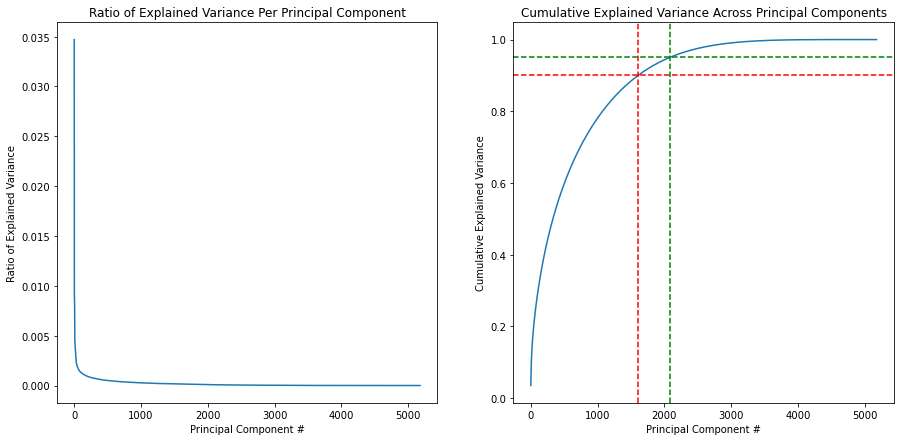

In [59]:
plot_explained_variance(var_ratio, cumulative_var, idx_90, idx_95)

If we wanted to keep 95% of the variance in our dataset, we could cut down > 5800 input features to ~2100 principal components. Still, the 50% of the variance is not explained by one or even ten PCs like we would ideally like to see.

In [60]:
# re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=idx_95+1)

#fit and transform the data here, create principal components
pcs = pca.fit_transform(scaled)

**"PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed."**

In [61]:
loadings = pd.DataFrame(pca.components_.T, index=regions.columns)
loadings

,0,1,2,3,4,5,6,7,8,9,...,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079
precip_most_exposed_0,0.001112,-0.003851,-0.003880,-0.001020,-0.002023,-0.002265,-0.000779,-0.005946,-0.001525,-0.001043,...,-0.003692,-0.006521,-0.006422,-0.004425,-0.010240,0.003741,-0.002330,-0.008016,0.006797,-0.003385
precip_most_exposed_1,0.001218,-0.003488,-0.001202,-0.004349,0.001069,0.000934,0.001038,-0.006267,-0.002484,0.000157,...,-0.003551,-0.007655,-0.002220,0.007823,-0.005584,0.021523,-0.013113,0.009233,0.001051,-0.003631
precip_most_exposed_2,0.000926,-0.001072,-0.001645,-0.003314,-0.001978,-0.000875,-0.000111,-0.006426,-0.002802,0.001053,...,0.013588,0.023951,0.012594,-0.010292,0.019280,-0.011510,0.012081,0.007615,-0.020010,-0.000556
precip_most_exposed_3,0.001042,-0.001223,-0.001645,-0.002906,-0.002314,0.000712,0.000836,-0.006787,-0.002814,0.001855,...,-0.006596,-0.007731,0.004372,0.000282,0.003708,0.001738,0.011335,0.001315,0.008104,0.003412
precip_most_exposed_4,0.000964,-0.001918,-0.000910,-0.002187,-0.003102,0.000900,-0.000313,-0.006277,-0.001031,0.002122,...,0.001663,-0.005042,0.003613,0.007321,-0.002538,0.003459,0.003750,-0.008398,0.002897,0.005087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_speed_max_4,-0.008156,0.010091,0.007284,0.007253,0.009487,-0.002194,-0.002315,0.018256,0.004265,0.004471,...,-0.014242,-0.011482,0.024359,0.011658,0.006107,0.036472,-0.056359,-0.031590,0.027410,-0.029433
wind_speed_max_5,-0.007789,0.012110,0.003133,0.007681,0.007519,-0.002982,0.001834,0.018595,0.005366,0.002049,...,0.001859,0.021923,-0.037305,-0.014152,0.004637,0.012523,0.056470,0.022978,0.004488,0.005645
wind_speed_max_72hr,-0.012719,0.014870,0.009793,0.012925,0.010861,-0.000691,0.002101,0.017878,0.004099,-0.000129,...,0.000441,0.005904,0.002035,-0.030891,0.037181,0.003141,-0.025046,0.005970,0.009228,-0.014144
precip_72hr,0.002052,-0.004923,-0.003927,-0.005082,-0.001730,-0.001272,0.000078,-0.010839,-0.003989,0.000047,...,0.003711,0.005742,0.002629,-0.003943,0.001703,0.007320,-0.002199,0.005084,-0.007165,-0.004244


**"Another useful way to interpret PCA is by computing the correlations between the original variable and the principal components."**

In [62]:
loadings_sqrt = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings_sqrt,
                              columns=['PC'+str(i) for i in range(1, idx_95+2)],
                              index=regions.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2071,PC2072,PC2073,PC2074,PC2075,PC2076,PC2077,PC2078,PC2079,PC2080
precip_most_exposed_0,0.014415,-0.026363,-0.025549,-0.006679,-0.013012,-0.014100,-0.004783,-0.032771,-0.007793,-0.004870,...,-0.002163,-0.003819,-0.003759,-0.002583,-0.005967,0.002178,-0.001355,-0.004658,0.003946,-0.001957
precip_most_exposed_1,0.015787,-0.023875,-0.007915,-0.028481,0.006876,0.005812,0.006378,-0.034540,-0.012696,0.000735,...,-0.002081,-0.004483,-0.001300,0.004567,-0.003254,0.012529,-0.007626,0.005365,0.000610,-0.002099
precip_most_exposed_2,0.012005,-0.007335,-0.010833,-0.021702,-0.012721,-0.005447,-0.000681,-0.035420,-0.014322,0.004914,...,0.007962,0.014027,0.007372,-0.006008,0.011235,-0.006700,0.007025,0.004425,-0.011616,-0.000322
precip_most_exposed_3,0.013506,-0.008371,-0.010834,-0.019032,-0.014879,0.004430,0.005136,-0.037405,-0.014383,0.008659,...,-0.003865,-0.004528,0.002559,0.000165,0.002161,0.001012,0.006592,0.000764,0.004704,0.001972
precip_most_exposed_4,0.012492,-0.013127,-0.005994,-0.014321,-0.019947,0.005602,-0.001922,-0.034596,-0.005272,0.009907,...,0.000975,-0.002953,0.002115,0.004274,-0.001479,0.002014,0.002181,-0.004880,0.001682,0.002940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_speed_max_4,-0.105694,0.069080,0.047964,0.047502,0.061004,-0.013655,-0.014217,0.100621,0.021798,0.020872,...,-0.008345,-0.006725,0.014259,0.006806,0.003559,0.021232,-0.032775,-0.018356,0.015911,-0.017013
wind_speed_max_5,-0.100934,0.082897,0.020631,0.050301,0.048353,-0.018559,0.011267,0.102490,0.027429,0.009565,...,0.001089,0.012840,-0.021837,-0.008262,0.002702,0.007290,0.032840,0.013352,0.002605,0.003263
wind_speed_max_72hr,-0.164817,0.101790,0.064479,0.084646,0.069845,-0.004303,0.012903,0.098538,0.020949,-0.000601,...,0.000258,0.003458,0.001191,-0.018033,0.021667,0.001829,-0.014565,0.003469,0.005357,-0.008176
precip_72hr,0.026597,-0.033699,-0.025857,-0.033283,-0.011124,-0.007920,0.000476,-0.059740,-0.020387,0.000219,...,0.002175,0.003363,0.001539,-0.002302,0.000993,0.004261,-0.001279,0.002954,-0.004159,-0.002453


In [63]:
pc_corr_list = []

for i in range(1, 11):
    col = 'PC'+str(i)
    pc_corr = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[0:10]
    pc_corr_list.append(pc_corr)
    
top_ten_pc_corrs = pd.concat(pc_corr_list, axis=1)
top_ten_pc_corrs.shape

(92, 10)

In [64]:
def color_realvals_green(val):
    """
    Takes a value and returns a string with the css 
    property `'color: green'` for real values, black otherwise.
    """
    color = 'lime' if np.isnan(val) == False else ''
    return 'background-color: %s' % color

In [65]:
s = top_ten_pc_corrs.style.applymap(color_realvals_green)
s

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
regobs_danger_avalanche_danger_0_5,0.595472,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_danger_avalanche_danger_0_4,0.594609,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_danger_avalanche_danger_0_7,0.587941,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_danger_avalanche_danger_0_6,0.586832,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_danger_avalanche_danger_0_2,0.586331,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_danger_avalanche_danger_0_3,0.584735,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_problem_destructive_size_0_4,0.547323,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_problem_destructive_size_0_5,0.546409,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_problem_destructive_size_0_2,0.542843,nan,nan,nan,nan,nan,nan,nan,nan,nan
regobs_problem_destructive_size_0_7,0.538543,nan,nan,nan,nan,nan,nan,nan,nan,nan


# t-SNE

t-SNE, or t-distributed stochastic neighbor embedding, is another feature reduction technique that we can use to try and distill which input features are important. We can do this by mapping input data in high dimensions to only 2 or 3 dimensions to see "clusters" of points. This would tell us how similar two clusters are to each other, since the t-SNE algorithm relies on the Euclidean distance between points, and since t-SNE tries to preserve this distance even when mapping points to lower dimensions.

If you are interested in learning more about t-SNE and how it is similar or different from PCA, the Wikipedia page and this DataCamp tutorial have more information:
- https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
- https://www.datacamp.com/community/tutorials/introduction-t-sne

**NOTE**: Once we are happy with the PCs, Scikit-Learn recommends inputing an input data array X that has < 50 features in it. They say that inputting X with a high number of dimensions leads to noise.

In [66]:
tsne2d = TSNE(n_components=2, random_state=42).fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=42).fit_transform(X)

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


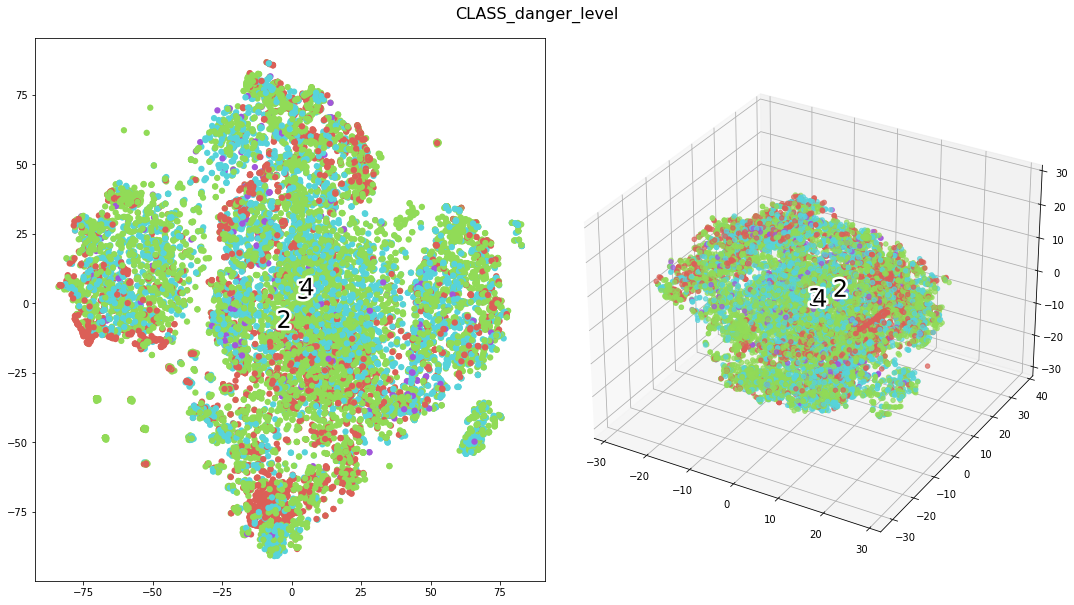

In [67]:
col = 'CLASS_danger_level'
plot_data_clusters(tsne2d, tsne3d, y[col].values, col)

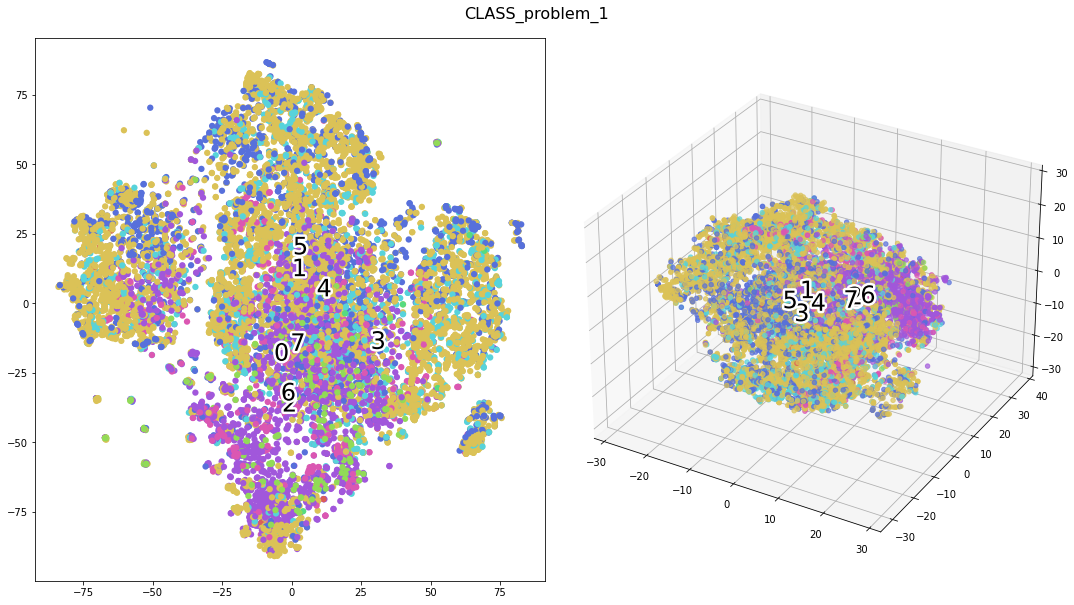

In [68]:
col = 'CLASS_problem_1'
plot_data_clusters(tsne2d, tsne3d, y[col].values, col)

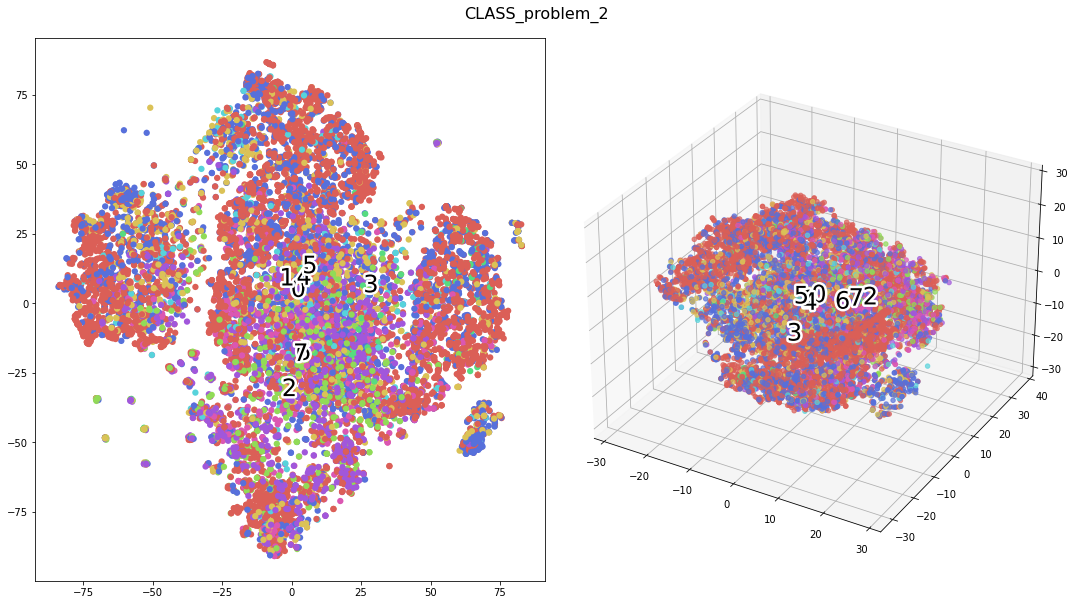

In [69]:
col = 'CLASS_problem_2'
plot_data_clusters(tsne2d, tsne3d, y[col].values, col)

t-SNE did not give us much hope of separating out the data by danger level or by avalanche problem 1 or 2 in an absolute sense. This means that many of the avalanche problems are likely inter-related and are often difficult to differentiate between completely. Many times, different avalanche problems (and certainly danger levels) have almost identical input features either from RegObs or Varsom.

# Recursive Feature Elimination

We can also use several different models to evaluate or rank input feature importance by slowly eliminating features from a model and seeing how that affects performance. This is called recursive feature elimination. To learn more about how this is implemented in Scikit-Learn, please see [this](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) link.

**Note**: Some models in Scikit-Learn only support predicting on a 1D array of target variables. In this case, you will have first have to wrap your model to a `MultiOutputClassifier` object, and *then* feed it into RFE.
- https://scikit-learn.org/stable/modules/multiclass.html

Additionally, you should note that running RFE with classes like an SVM or RandomForest model will take a **very** long time.

In [70]:
def rfe(X, y, num_features, discard_per_iter, col_name):
    """
    Recurisve Feature Elimination on input data X and output (target) column y.
    
    Arguments:
        X(DataFrame): the entire input dataset
        y(DataFrame): a singular label that you want to score on
        num_features(int): the number of features you want to keep
        discard_per_iter(int): how many features to discard (eliminate) per iteration
        col_name(str): the name of the column you are scoring on (y)
    
    Returns:
        (array) The indices (rank) of the features as they are eliminated.
    """
    # let's time the whole process
    start = time.time()

    # select a model
    rfc = RandomForestClassifier()

    # use this if the model supports multioutput classification
    model = rfc

    # and this if it doesn't
    #model = sklearn.multioutput.MultiOutputClassifier(...)

    # create the RFE object
    eliminator = RFE(estimator=model, n_features_to_select=num_features, step=discard_per_iter, verbose=0)

    # X and y were defined in the previous section on feature importances
    print('Starting RFE to select top {} features for {} label....'.format(num_features, col_name))
    eliminator.fit(X, y)

    end = time.time()
    print('Done!')

    total_time = end - start
    print_time = np.round(total_time / 60, 3)
    print('RFE took {} minutes to complete.\n'.format(print_time))
    
    return eliminator.ranking_

In [71]:
# what does RFE think are the most important features
# for danger level and the first 2 avalanche problems?
n_features = 50
discard = 50
danger_col_rank = rfe(X, y_danger, n_features, discard, 'danger level')
prob1_col_rank = rfe(X, y_problem_1, n_features, discard, 'problem 1')
prob2_col_rank = rfe(X, y_problem_2, n_features, discard, 'problem 2')

Starting RFE to select top 50 features for danger level label....
Done!
RFE took 13.249 minutes to complete.

Starting RFE to select top 50 features for problem 1 label....
Done!
RFE took 13.241 minutes to complete.

Starting RFE to select top 50 features for problem 2 label....
Done!
RFE took 13.249 minutes to complete.



In [76]:
# take the top n most important features from each round of rfe
elim_danger = pd.DataFrame(prob1_col_rank, index=X.columns, 
                           columns=['danger']).sort_values(by='danger', ascending=True)[:100]

elim_prob1 = pd.DataFrame(prob1_col_rank, index=X.columns, 
                          columns=['prob_1']).sort_values(by='prob_1', ascending=True)[:100]

elim_prob2 = pd.DataFrame(prob2_col_rank, index=X.columns, 
                          columns=['prob_2']).sort_values(by='prob_2', ascending=True)[:100]

# and then merge them together 
elim_probs = pd.concat([elim_prob1, elim_prob2], axis=1)
elim_all = pd.concat([elim_danger, elim_probs], axis=1)

# sort alphabetically, all columns with same importance
elim_all.head(n_features).sort_index()

,danger,prob_1,prob_2
precip_0,1.0,1.0,1.0
precip_3,1.0,1.0,1.0
precip_4,1.0,1.0,1.0
precip_5,1.0,1.0,1.0
precip_72hr,1.0,1.0,1.0
precip_most_exposed_0,1.0,1.0,1.0
precip_most_exposed_1,1.0,1.0,1.0
precip_most_exposed_2,1.0,1.0,1.0
precip_most_exposed_3,1.0,1.0,1.0
precip_most_exposed_4,1.0,1.0,1.0


In [78]:
elim_all.tail(n_features)

,danger,prob_1,prob_2
regobs_tests_fracture_depth_0_3,2.0,2.0,2.0
regobs_danger_avalanche_danger_1_3,2.0,2.0,1.0
regobs_activity_estimated_num_0_4,2.0,2.0,1.0
regobs_activity_estimated_num_0_7,2.0,2.0,2.0
regobs_activity_estimated_num_0_3,2.0,2.0,2.0
temp_fl_start_0_4,2.0,2.0,2.0
regobs_tests_fracture_depth_0_6,2.0,2.0,2.0
wind_chg_start_18_1,2.0,2.0,2.0
temp_fl_start_0_0,2.0,2.0,NaN
temp_fl_start_0_5,2.0,2.0,2.0


So the Recursive Feature Elimination models don't agree on the order of *all* eliminated features (as the printout to `.tail()` above shows), but the top 50 most important features **do** all agree. That is very surprising. According to the RFE classification models, the most important features are:

- temperature min, max, and freezing level up to a 5 days back
- precipitation up to a 5 days back
- wind speed and wind speed change up to 4 days back
- and the danger level up to a week back

# Comments

**Summary**: So far, we have performed correlation analysis, PCA, and calculated feature importances to determine which input columns are the most important for predicting our labels. This shows that we can eliminate many of the input columns, and perhaps some of the labels (meaning we can't do a good job of predicting them, like for avlanche problem 3 which is almost never used).

**Recommendations**: 
Based on this analysis, I would recommend keeping the following columns if using Varsom data:
- avalanche problems from the previous day
- dsize from the previous day
- temperature min, max, and freezing level from the day of
- level min and max
- danger level from the previous day

And if only using RegObs data:
- temperature maximum freezing level up to a week back
- precipitation up to a week back
- wind speed and change in wind speed for up to 2 days back
- snowpack conditions

I also think we should keep the aspect columns, although it may be as simple as using a separate linear regression model to predict the next day's aspect values from the previous day's.